Summary
===============

Geospatial data often comes in the forms of samples taken at different points, when this occours a common next step is interpolation. 
An example of this is Airbourne LiDAR, where a laser range finder is scanned over the ground underneath the aircraft. The produces a cloud of scattered points, and often the next step is build a Digital Elevation Model (DEM) from these scattered points. 

In [15]:
import numpy as np
import math
import os
from PIL import Image
#import gdal
import matplotlib.pyplot as plt
from scipy import interpolate

The Data
===============


In [16]:
def downloadDEMFromCGIAR(lat,lon):
    ''' Download a DEM from CGIAR FTP repository '''
    fileName = lonLatToFileName(lon,lat)+'.zip'

    ''' Check to see if we have already downloaded the file '''
    if fileName not in os.listdir('.'):
        os.system('''wget --user=data_public --password='GDdci' http://data.cgiar-csi.org/srtm/tiles/GeoTIFF/'''+fileName)
    os.system('unzip '+fileName)

def lonLatToFileName(lon,lat):
    ''' Compute the input file name '''
    tileX = int(math.ceil((lon+180)/5.0))
    tileY = -1*int(math.ceil((lat-65)/5.0))
    inputFileName = 'srtm_'+str(tileX).zfill(2)+'_'+str(tileY).zfill(2)
    return(inputFileName)

lon,lat = -155.48647818,19.6662251
inputFileName = lonLatToFileName(lon,lat)
#downloadDEMFromCGIAR(lat,lon)

utmZone = int((math.floor((lon + 180)/6) % 60) + 1)

''' Check to see if file is in northern or southern hemisphere '''
if lat<0:
    EPSGCode = 'EPSG:327'+str(utmZone)
else:
    EPSGCode = 'EPSG:326'+str(utmZone)

!! gdalwarp -q -te -155.75 19.25 -155.25 19.75 -srcnodata -32768 -dstnodata 0 srtm_05_09.tif subset.tif
#os.system('gdalwarp -q -t_srs '+EPSGCode+' -tr 100 -100 -r cubic subset.tif warped.tif')

['dyld: Library not loaded: @rpath/libncurses.6.dylib',
 '  Referenced from: /Users/cgcooke/anaconda3/envs/LiDAR/lib/libspatialite.7.dylib',
 '  Reason: image not found']

In [17]:
data = np.asarray(Image.open('warped.tif'))

plt.imshow(data)
plt.colorbar()
plt.show()

y_range = data.shape[0]
x_range = data.shape[1]
num_samples = 10**5
xArray = np.zeros(num_samples)
yArray = np.zeros(num_samples)
heightArray = np.zeros(num_samples)

for sample_num in range(0,num_samples):
    x_idx = np.random.randint(0,x_range)
    y_idx = np.random.randint(0,y_range)
    
    xArray[sample_num] = x_idx
    yArray[sample_num] = y_idx
    heightArray[sample_num] = data[y_idx,x_idx]

FileNotFoundError: [Errno 2] No such file or directory: 'warped.tif'

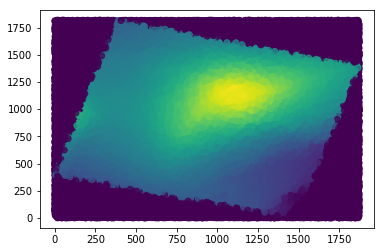

In [48]:
plt.scatter(xArray,yArray,c=heightArray,alpha=0.75)
plt.show()

Interpolation
===============

Ultimately, there is no universally correct choice of interpolation method to use. However it is useful to know the mechanics associated with going from scattered points to an interpolated array for a number of different methods. 

In [49]:
numIndexes = 500
xi = np.linspace(np.min(xArray), np.max(xArray),numIndexes)
yi = np.linspace(np.min(yArray), np.max(yArray),numIndexes)

One option is linear interpolation, which can be performed using scipy.interpolate.

In [63]:
XI, YI = np.meshgrid(xi, yi)
points = np.vstack((xArray,yArray)).T
values = np.asarray(heightArray)
points = np.asarray(points)
DEM = interpolate.griddata(points, values, (XI,YI), method='linear')

Contour plots
===============

Contour plots are useful for visualzing Digital Elevation Models, Our first step is to create the contour lines, with a 25m contour interval as follows :


We can map the array to an image using imshow, an alternative is to use plt.contourf, to "fill in" the contours.

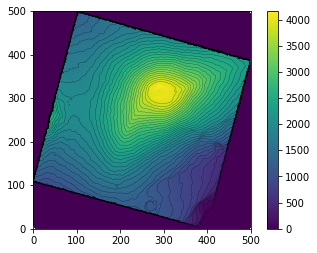

In [64]:
levels = np.arange(0,4000,100)
plt.contour(DEM, levels,linewidths=0.2,colors='k')
plt.imshow(DEM,origin='lower')
plt.colorbar()
plt.show()

Displaying in Google Earth
===

We will first make some changes to the plotting, so that we can plot it without a border. 
After this, we can then add a coordinate system to the image, allowing it to be viewed in Google Earth.

In [65]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.contour(DEM, levels,linewidths=0.2,colors='k')
plt.imshow(DEM,origin='lower')
plt.savefig('ContourMapTight.png',dpi=900)
plt.close()

In [70]:
img  = np.asarray(Image.open('ContourMapTight.png'))

I developed the boilderplate code from this [example](http://gis.stackexchange.com/questions/58517/python-gdal-save-array-as-raster-with-projection-from-other-file)

In [68]:
def arrayToRaster(array,fileName,EPSGCode,xMin,xMax,yMin,yMax,numBands):
    xPixels = array.shape[1]  # number of pixels in x
    yPixels = array.shape[0]  # number of pixels in y
    pixelXSize =(xMax-xMin)/xPixels # size of the pixel in X direction     
    pixelYSize = -(yMax-yMin)/yPixels # size of the pixel in Y direction

    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(fileName,xPixels,yPixels,numBands,gdal.GDT_Byte, options = ['PHOTOMETRIC=RGB'])
    dataset.SetGeoTransform((xMin,pixelXSize,0,yMax,0,pixelYSize))  

    datasetSRS = osr.SpatialReference()
    datasetSRS.ImportFromEPSG(EPSGCode)
    dataset.SetProjection(datasetSRS.ExportToWkt())
    
    for i in range(0,numBands):
        dataset.GetRasterBand(i+1).WriteArray(array[:,:,i])

    dataset.FlushCache()  # Write to disk.

In [71]:
numBands = 3
arrayToRaster(img,'OUT.TIF',EPSGCode,np.min(xArray),np.max(xArray),np.min(yArray),np.max(yArray),numBands)

NameError: name 'gdal' is not defined

Finally, we are left with a TIFF file called "OUT.TIFF" which we can open in Google Earth. Simply go to File -> Import, and open the GeoTIFF. 